# Homework 4

## References

+ Lectures 13-16 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os
from pprint import pprint

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

## Student details

+ **Name: R Murali Krishnan**
+ **Email: mrajase@purdue.edu**

# Problem 1 - Estimating the mechanical properties of a plastic material from molecular dynamics simulations

First, make sure that [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/stress_strain.txt) dataset is visible from this Jupyter notebook.
You may achieve this by either:

+ Downloading the data file and then manually upload it on Google Colab. The easiest way is to click on the folder icon on the left of the browser window and click on the upload button (or drag and drop the file). Some other options are [here](https://colab.research.google.com/notebooks/io.ipynb).
+ Downloading the file to the working directory of this notebook with this code:

In [2]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/stress_strain.txt"
download(url)

It's up to you what you choose to do.
If the file is in the right place, the following code should work:

In [3]:
data =  np.loadtxt('stress_strain.txt')

The dataset was generated using a molecular dynamics simulation of a plastic material (thanks to [Professor Alejandro Strachan](https://engineering.purdue.edu/MSE/people/ptProfile?id=33239) for sharing the data!).
Specifically, Strachan's group did the following:
- They took a rectangular chunk of the material and marked the position of each one of its atoms;
- They started applying a tensile force along one dimension.
The atoms are coupled together through electromagnetic forces, and they must all satisfy Newton's law of motion.
- For each value of the applied tensile force, they marked the stress (force be unit area) in the middle of the material and the corresponding strain of the material (percent elongation in the pulling direction).
- Eventually, the material entered the plastic regime and broke.
Here is a visualization of the data:

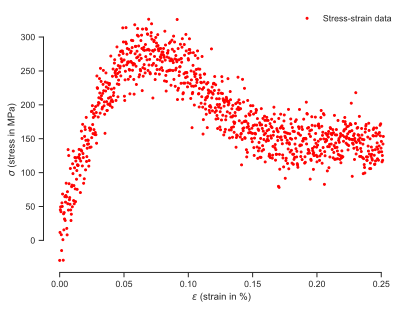

In [4]:
# Strain 
x = data[:, 0]
# Stress in MPa
y = data[:, 1]

plt.figure()
plt.plot(
    x,
    y,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True)

Note that you don't necessarily get a unique stress for each particular value of the strain.
This is because the atoms are jiggling around due to thermal effects.
So, there is always this "jiggling" noise when measuring the stress and the strain.
We want to process this noise to extract what is known as the [stress-strain curve](https://en.wikipedia.org/wiki/Stress–strain_curve) of the material.
The stress-strain curve is a macroscopic property of the material, affected by the fine structure, e.g., the chemical bonds, the crystalline structure, any defects, etc.
It is a required input to the mechanics of materials.

## Part A - Fitting the stress-strain curve in the elastic regime
The very first part of the stress-strain curve should be linear.
It is called the *elastic regime*.
In that region, say $\epsilon < \epsilon_l=0.04$, the relationship between stress and strain is:

$$
\sigma(\epsilon) = E\epsilon.
$$

The constant $E$ is known as the *Young modulus* of the material.
Assume that you measure $\epsilon$ without noise, but your measured $\sigma$ is noisy.

### Subpart A.I
First, extract the relevant data for this problem, split it into training and validation datasets, and visualize the training and validation datasets using different colors.

Text(0.5, 0.98, 'Linear trend in the data - $\\epsilon <$ 0.04')

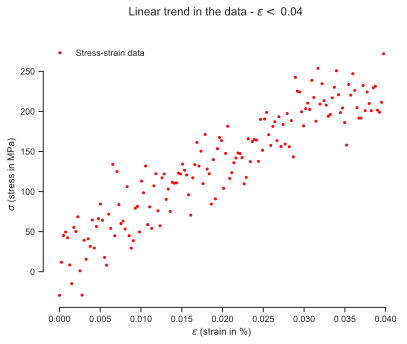

In [5]:
# The point at which the stress-strain curve stops being linear
epsilon_l = 0.04
# Relevant data (this is a nice way to get the linear part of the stresses and straints)
x_linear = x[x < 0.04]
y_linear = y[x < 0.04]

# Visualize to make sure you have the right data
plt.figure()
plt.plot(
    x_linear,
    y_linear,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True)
plt.suptitle("Linear trend in the data - " + r"$\epsilon <$" + f" {epsilon_l:0.2f}")

Split your data into training and validation.

**Hint:** You may use [`sklearn.model_selection.train_test_split``](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) if you wish.

**Solution:** <br>

According to `sklearn.model_selection.train_test_split` API docs, the default split of train-to-test is 3:1, which is reasonable.
<br><br>
**Note**: `sklearn.model_selection.train_test_split` API returns train/test values in the following order,
```python
(X_train, X_valid, Y_train, Y_valid) <- train_test_split(X_data, Y_data)
```

In [6]:
# Split the data into training and validation datasets
# Hint: Consult the lecture notes
from sklearn.model_selection import train_test_split

# default train-test seems to be 3:1 which seems reasonable 
# refer: https://github.com/scikit-learn/scikit-learn/blob/d99b728b3a7952b2111cf5e0cb5d14f92c6f3a80/sklearn/model_selection/_split.py#L2573
#
# Note: This API returns the value as (X_train, X_test, Y_train, Y_test) <- train_test_split(X_data, Y_data)
x_train, x_valid, y_train, y_valid = train_test_split(x_linear, y_linear, random_state=43)

Use the following to visualize your split:

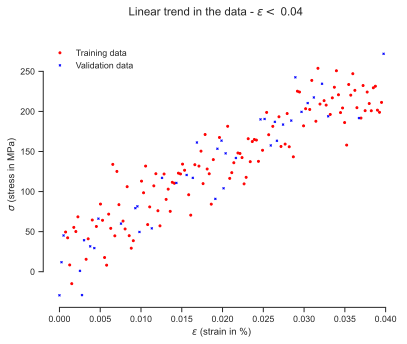

In [7]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
plt.suptitle("Linear trend in the data - " + r"$\epsilon <$" + f" {epsilon_l:0.2f}")
sns.despine(trim=True)


### Subpart A.II
Perform Bayesian linear regression with the evidence approximation to estimate the noise variance and the hyperparameters of the prior.
<br><br><br>
**Solution**: Let's use the `sklearn` API for performing the bayesian linear regression. The following references are helpful.

- These references are helpful [Lecture 15: Evidence Approximation](https://predictivesciencelab.github.io/data-analytics-se/lecture15/hands-on-15.1.html#). 
- `sklearn.linear_model.BayesianRidge` API documentation page [API docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html)

The ridge linear model in `sklearn` has two sets of parameters
- $\mathcal{w}$, the weights of the linear model
- $\alpha$, the regularization parameter, which follows a `Gamma` distribution.

The Bayesian linear ridge regression model assumes a zero-mean Gaussian with $\lambda^{-1}$ variance as a prior over the weights, i.e., $\mathcal{w} \sim \mathcal{N}(0, \lambda^{-1}, \mathbf{I}_p)$. 
<br>
This contributes to the regularization of the joint-probability density of the parameters.

In [8]:
from sklearn.linear_model import BayesianRidge

# Fit a Bayesian Ridge Regression model
# Notes:
# 1. Since we want to fit a 'linear' model with zero intercept pass `fit_intercept=False`
# 2. BayesianRidge(...).fit(...) takes `X` of dimensions (n_samples, n_features). 
#    Since we have only 1-feature (linear), we need to `reshape` input vector to size (-1, 1)
bayesian_linear_model = BayesianRidge(fit_intercept=False).fit(x_train.reshape(-1, 1), y_train)

# 
sigma = np.sqrt(1.0 / bayesian_linear_model.alpha_)
print('Estimated precision of noise, sigma = {0:1.2f}'.format(sigma))
alpha = np.sqrt(1.0 / bayesian_linear_model.lambda_)
print('Estimated precision of the weight, alpha = {0:1.2f}'.format(alpha))

m = bayesian_linear_model.coef_
print(f"Posterior mean w: {m}")

S = bayesian_linear_model.sigma_
print(f"Posterior covariance w: {S}")

Estimated precision of noise, sigma = 30.65
Estimated precision of the weight, alpha = 6346.59
Posterior mean w: [6345.47825599]
Posterior covariance w: [[14152.42296275]]


### Subpart A.III
Calculate the mean square error of the validation data.

**Solution**: <br>
For this we need to first get predictions from our fitted model, lets call that $\hat{y}$.
<br>
We have reserved a set of observations in `y_valid` ( $y_{\text{valid}}$ ) for this purpose.

The mean squared error is $\mathbb{E}[(\hat{y} - y_{\text{valid}})^2]$

Code reference: 

In [9]:
y_valid_predict_mean, y_valid_predict_std = bayesian_linear_model.predict(x_valid.reshape(-1, 1), return_std=True)
mse = np.mean((y_valid_predict_mean - y_valid)**2)
print(f"Mean squared error is {mse:1.2f}")

Mean squared error is 703.63


### Subpart A.IV
Make the observations vs predictions plot for the validation data.

**Solution**: <br>


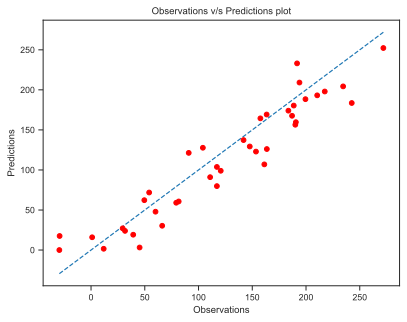

In [10]:
fig, ax = plt.subplots()
domain = np.linspace(y_valid.min(), y_valid.max())
ax.plot(domain, domain, '--')
ax.plot(y_valid, y_valid_predict_mean, 'ro')
ax.set(title="Observations v/s Predictions plot", 
       xlabel="Observations",
       ylabel="Predictions")
plt.show()

### Subpart A.V
Compute and plot the standardized errors for the validation data.

**Solution** The linear model seems to cover almost all validation data within the 95% interval.

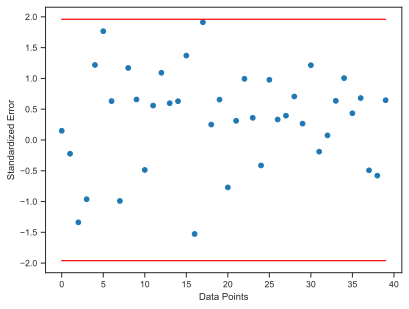

In [11]:
std_err = (y_valid - y_valid_predict_mean) / y_valid_predict_std

fig, ax = plt.subplots()
ax.plot(std_err, 'o')
ax.plot(-1.96 * np.ones(len(y_valid)), 'r')
ax.plot(1.96 * np.ones(len(y_valid)), 'r')
ax.set(ylabel="Standardized Error", xlabel="Data Points")
plt.show()

### Subpart A.VI
Make the quantile-quantile plot of the standardized errors.

**Soluation:** <br>
The procedure for producing the quantile-quantile plot is found [here](https://predictivesciencelab.github.io/data-analytics-se/lecture15/hands-on-15.3.html)

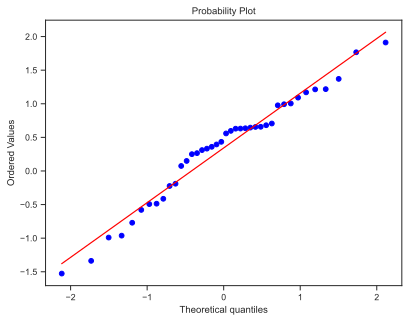

In [12]:
# SciPy provides a high-level API for Q-Q plots
# through `scipy.stats.probplot`
fig, ax = plt.subplots()
_ = st.probplot(std_err, dist=st.norm, plot=ax)

### Subpart A.VII
Visualize your epistemic and the aleatory uncertainty about the stress-strain curve in the elastic regime.
<br>
**Solution:**<br>


In [13]:
# Fuzzy!!!

### Subpart A. VIII
Visualize the posterior of the Young modulus E conditioned on the data.

**Solution:** From the `model` object extract the posterior mean, and the posterior covariance matrix of the weights.

Posterior mean : 6345.48 MPa, std: 14152.42 MPa


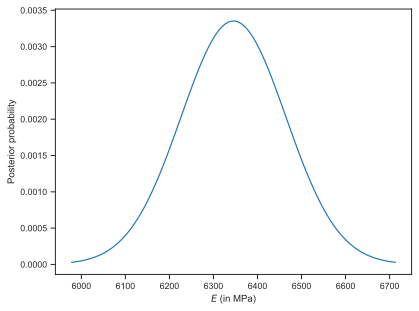

In [14]:
# The posterior mean of the weights is here
m_norm = bayesian_linear_model.coef_
# The posterior covariance matrix for the weights is here
S_norm = bayesian_linear_model.sigma_
print("Posterior mean : {0:.2f} MPa, std: {1:.2f} MPa".format(m_norm.item(), S_norm.item()))
# Create a Normal random variable to represent this
E_post = st.norm(loc=m_norm[0], scale=np.sqrt(S_norm[0, 0])) # Plot the PDF of E_post
Es = np.linspace(E_post.ppf(0.001), E_post.ppf(0.999), 100)
fig, ax = plt.subplots()
ax.plot(Es, E_post.pdf(Es))
ax.set_xlabel('$E$ (in MPa)')
ax.set_ylabel('Posterior probability')
plt.show()

### Subpart A.IX
Take five samples of stress-strain curve in the elastic regime and visualize them.

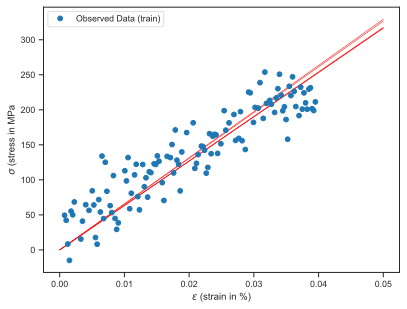

In [15]:
fig, ax = plt.subplots()
xx = np.linspace(0, 0.05, 100)
for i in range(5):
    E = E_post.rvs()
    yy = E * xx
    ax.plot(xx, yy, 'r', lw=0.5)
ax.plot(x_train, y_train, 'o', label="Observed Data (train)")
ax.set(xlabel='$\epsilon$ (strain in %)', ylabel="$\sigma$ (stress in MPa")
plt.legend(loc='best')
plt.show()

### Subpart A.X

Find the 95% centered credible interval for the Young modulus $E$.

In [16]:
E_l = E_post.ppf(0.025)
E_u = E_post.ppf(0.975)
print('E is in between {0:1.2f} and {1:1.2f} MPa with 95% probability!'.format(E_l, E_u))

E is in between 6112.31 and 6578.64 MPa with 95% probability!


### Subpart A.XI
If you had to pick a single value for the Young modulus $E$, what would it be and why?

**Solution:** Choosing the median value of the random variable as a suggestion. Use the `.median()` method for the random variables created by the SciPy API.

In [17]:
print('E* = {0:1.2f} MPa'.format(E_post.median()))

E* = 6345.48 MPa


## Part B - Estimate the ultimate strength

The pick of the stress-strain curve is known as the ultimate strength.
We want to estimate it.

### Subpart B.I - Extract training and validation data

Extract training and validation data from the entire dataset.

In [18]:
# your code here - Repeat as many text and code blocks as you like
x_train, x_valid, y_train, y_valid = train_test_split(x, y, random_state=43)

Use the following to visualize your split:

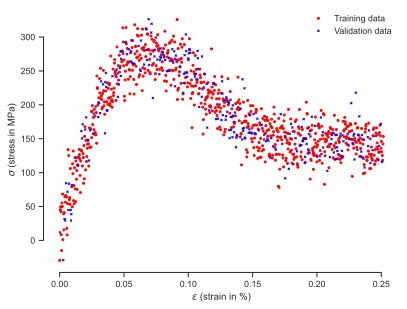

In [19]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True)

### Subpart B.II - Model the entire stress-strain relationship.
To do this, we will set up a generalized linear model to capture the entire stress-strain relationship.
Remember, you can use any model you want as soon as:
+ It is linear in the parameters to be estimated,
+ It has a well-defined elastic regime (see Part A).

I am going to help you set up the right model.
We will use the [Heavide step function](https://en.wikipedia.org/wiki/Heaviside_step_function) to turn on or off models for various ranges of $\epsilon$. The idea is quite simple: We will use a linear model for the elastic regime, and we are going to turn to a non-linear model for the non-linear regime.
Here is a model that has the right form in the elastic regime and an arbitrary form in the non-linear regime:

$$
f(\epsilon;E,\mathbf{w}_g) = E\epsilon \left[(1 - H(\epsilon - \epsilon_l)\right] + g(\epsilon;\mathbf{w}_g)H(\epsilon - \epsilon_l),
$$

where

$$
H(x) = \begin{cases}
0,\;\text{if}\;x < 0\\
1,\;\text{otherwise},
\end{cases}
$$

and $g$ is any function linear in the parameters $\mathbf{w}_g$.

You can use any model you like for the non-linear regime, but let's use a polynomial of degree $d$:

$$
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i.
$$

The full model can be expressed as:

$$
\begin{split}
f(\epsilon) &= 
\begin{cases}
h(\epsilon) = E \epsilon,\ \epsilon < \epsilon_l, \\
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i, \epsilon \geq \epsilon_l
\end{cases}\\
&= E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
\end{split}
$$

We could proceed with this model, but there is a small problem: It is discontinuous at $\epsilon = \epsilon_l$.
This is unphysical. We can do better than that!

To make the model nice, we force the $h$ and $g$ to match up to the first derivative, i.e., we demand that:

$$
\begin{split}
h(\epsilon_l) &= g(\epsilon_l)\\
h'(\epsilon_l) &= g'(\epsilon_l).
\end{split}
$$

We include the first derivative because we don't have a kink in the stress-strain. That would also be unphysical.
The two equations above become:

$$
\begin{split}
E\epsilon_l &= \sum_{i=0}^dw_i\epsilon_l^i\\
E &= \sum_{i=1}^diw_i\epsilon_l^{i-1}.
\end{split}
$$

We can use these two equations to eliminate two weights.
Let's eliminate $w_0$ and $w_1$.
All you have to do is express them in terms of $E$ and $w_2,\dots,w_d$.
So, there remain $d$ parameters to estimate.
Let's get back to the stress-strain model.

Our stress-strain model was:

$$
f(\epsilon) = E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
$$

We can now use the expressions for $w_0$ and $w_1$ to rewrite this using only all the other 
parameters.
I am going to spare you the details.
The result is:

$$
f(\epsilon) = E\epsilon + \sum_{i=2}^dw_i\left[(i-1)\epsilon_{l}^{i} - i \epsilon \epsilon_{l}^{i-1} + \epsilon^i\right]H(\epsilon - \epsilon_l).
$$

Okay.
This is still a generalized linear model. This is nice.
Write code for the design matrix:

In [22]:
# Complete this code to make your model:
def compute_design_matrix(Epsilon, epsilon_l, d):
    """Compute the design matrix for the stress-strain curve problem.
    
    Arguments:
        Epsilon     -     A 1D array of dimension N.
        epsilon_l   -     The strain signifying the end of the elastic regime.
        d           -     The polynomial degree.
    
    Returns:
        A design matrix N x d
    """
    # Sanity check
    assert isinstance(Epsilon, np.ndarray)
    assert Epsilon.ndim == 1, 'Pass the array as epsilon.flatten(), if it is two dimensional'
    n = Epsilon.shape[0]
    # The design matrix:
    Phi = np.ndarray((n, d))
    # The step function evaluated at all the elements of Epsilon.
    # You can use it if you want.
    Step = np.ones(n)
    Step[Epsilon < epsilon_l] = 0
    # Build the design matrix
    #
    # Note: Translate equations derived above into code
    Phi[:, 0] = Epsilon
    for i in range(2, d+1):
        Phi[:, i-1] = ((i - 1) * epsilon_l**i \
                      - i * Epsilon * epsilon_l**(i-1) \
                      + Epsilon**i) * Step
    return Phi

Visualize the basis functions here:

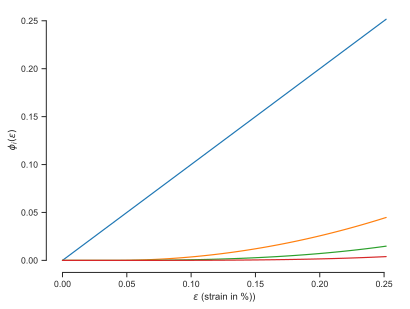

In [23]:
d = 4
eps = np.linspace(0, x.max(), 100)
Phis = compute_design_matrix(eps, epsilon_l, d)
fig, ax = plt.subplots(dpi=100)
ax.plot(eps, Phis)
ax.set_xlabel('$\epsilon$ (strain in %))')
ax.set_ylabel('$\phi_i(\epsilon)$')
sns.despine(trim=True)

### Subpart B.III 

Fit the model using automatic relevance determination and demonstrate that it works well by doing everything we did above (MSE, observations vs. predictions plot, standardized errors, etc.).

In [24]:
from sklearn.linear_model import ARDRegression
Phi_train = compute_design_matrix(x_train, epsilon_l, d)
model = ARDRegression(fit_intercept=False).fit(Phi_train, y_train)

We perform the same set of set of procedures we have from **Subpart A.II to Subpart A.VI**.

In [25]:
# Mean Squared Error
Phi_valid = compute_design_matrix(x_valid, epsilon_l, d)
y_valid_p_mean, y_valid_p_std = model.predict(Phi_valid, return_std=True)
MSE = np.mean((y_valid_p_mean - y_valid) ** 2)
print('MSE = {0:1.2f}'.format(MSE))

MSE = 686.52


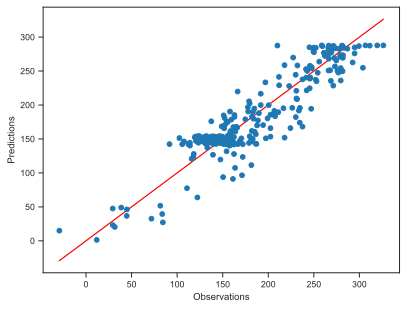

In [26]:
# Observations vs Predictions plot
fig, ax = plt.subplots(dpi=100)
yys = np.linspace(y_valid.min(), y_valid.max())
ax.plot(yys, yys, 'r')
ax.plot(y_valid, y_valid_p_mean, 'o')
ax.set_xlabel('Observations')
ax.set_ylabel('Predictions')
plt.show()

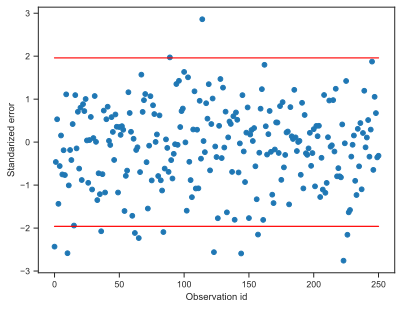

In [27]:
# Stardized Error of Predictions
std_errs = (y_valid_p_mean - y_valid) / y_valid_p_std
fig, ax = plt.subplots(dpi=100)
ax.plot(std_errs, 'o')
obs_ids = np.arange(std_errs.shape[0])
ax.plot(obs_ids, 1.96 * np.ones(obs_ids.shape[0]), 'r')
ax.plot(obs_ids, -1.96 * np.ones(obs_ids.shape[0]), 'r')
ax.set_xlabel('Observation id')
ax.set_ylabel('Standarized error')
plt.show()

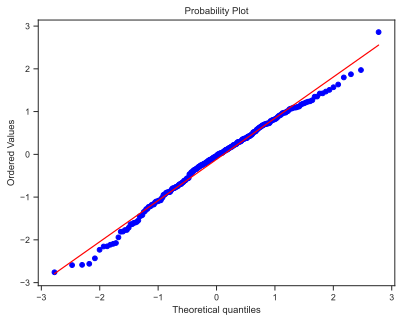

In [28]:
# Q-vs-Q plot
fig, ax = plt.subplots(dpi=100)
_ = st.probplot(std_errs, dist=st.norm, plot=ax)

### Subpart B.IV
Visualize the epistemic and aleatory uncertainty in the stess-strain relation.

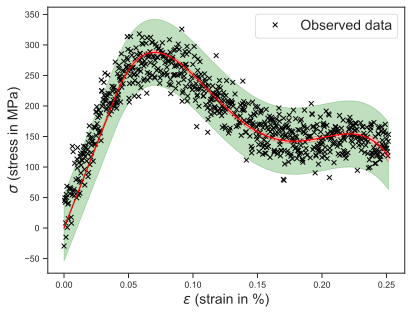

In [29]:
sigma = np.sqrt(1.0 / model.alpha_)
xx = np.linspace(0.0, x.max(), 100)
Phi_xx = compute_design_matrix(xx, epsilon_l, d)
# Use the model to get the predictive mean and standard deviation:
yy_mean, yy_measured_std = model.predict(Phi_xx, return_std=True)
# Separate the epistemic uncertainty
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
# Plot
fig, ax = plt.subplots(dpi=100)
ax.plot(x_train, y_train, 'kx', label='Observed data')
ax.plot(xx, yy_mean, 'r')
# Epistemic lower bound
yy_le = yy_mean - 2.0 * yy_std
# Epistemic upper bound
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory lower bound
yy_lae = yy_mean - 2.0 * yy_measured_std
# Episemic + aleatory upper bound
yy_uae = yy_mean + 2.0 * yy_measured_std
ax.fill_between(xx, yy_le, yy_ue, color='red', alpha=0.25)
ax.fill_between(xx, yy_lae, yy_le, color='green', alpha=0.25)
ax.fill_between(xx, yy_ue, yy_uae, color='green', alpha=0.25)
# plot the data again
plt.xlabel('$\epsilon$ (strain in %)', fontsize=14)
plt.ylabel('$\sigma$ (stress in MPa)', fontsize=14)
plt.legend(loc='best', fontsize = 14);

### Subpart B.V - Extract the ultimate strength

Now, you will quantify your epistemic uncertainty about the ultimate strength.
The ultimate strength is the maximum of the stress-strain relationship.
Since you have epistemic uncertainty about the stress-strain relationship, you also have epistemic uncertainty about the ultimate strength.

Do the following:
- Visualize the posterior of the ultimate strength.
- Find a 95% credible interval for the ultimate strength.
- Pick a value for the ultimate strength.

**Hint:**
To characterize your epistemic uncertainty about the ultimate strength, you would have to do the following:
- Define a dense set of strain points between 0 and 0.25.
- Repeatedly:
    - Sample from the posterior of the weights of your model
    - For each sample, evaluate the stresses at the dense set of strain points defined earlier
    - For each sampled stress vector, find the maximum. This is a sample of the ultimate strength.

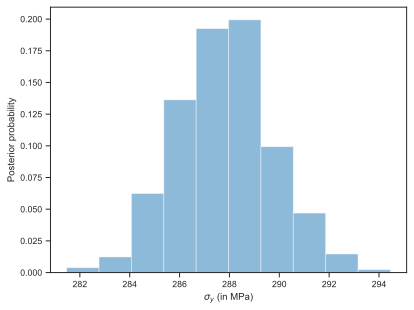

In [30]:
# Use Hands-on Activity 15.2
# The posterior mean of the weights is here (this is for the normalized features, however)
m_norm = model.coef_
# The posterior covariance matrix for the weights is here (also for the normalized features)
S_norm = model.sigma_ + 1e-6 * np.eye(model.sigma_.shape[0]) 
# The posterior of the weights
w_post = st.multivariate_normal(mean=m_norm, cov=S_norm)
# The number of samples to take
num_post_samples = 1000
# Storing the ultimate strength of each one of the posterior samples 
ultimate_strength_post_samples = np.ndarray((num_post_samples,))
# Start taking samples
for n in range(num_post_samples):
    w_sample = w_post.rvs()
    yy_sample = np.dot(Phi_xx, w_sample)
    ultimate_strength_post_samples[n] = np.max(yy_sample)
# Do the histogram
fig, ax = plt.subplots(dpi=100) 
ax.hist(ultimate_strength_post_samples, density=True, alpha=0.5) 
ax.set_xlabel('$\sigma_y$ (in MPa)')
ax.set_ylabel('Posterior probability')
plt.show()

# Problem 2 - Optimizing the performance of a compressor

In this problem, we will need [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/compressor_data.xlsx) dataset. The dataset was kindly provided to us by [Professor Davide Ziviani](https://scholar.google.com/citations?user=gPdAtg0AAAAJ&hl=en).
As before, you can either put it on your Google Drive or just download it with the code segment below:

In [32]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/compressor_data.xlsx"
download(url)

Note that this is an Excel file, so we need pandas to read it.
Here is how:

In [33]:
import pandas as pd
data = pd.read_excel('compressor_data.xlsx')
data.describe()

,T_e,DT_sh,T_c,DT_sc,T_amb,f,m_dot,m_dot.1,Capacity,Power,Current,COP,Efficiency
count,65.000000,65.0,65.000000,65.0,65.0,65.0,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,-6.615385,11.0,42.000000,8.0,35.0,60.0,127.618462,35.449573,6290.107692,1898.846154,8.446154,4.842769,0.628000
std,11.927767,0.0,12.272938,0.0,0.0,0.0,72.406200,20.112833,3908.344079,568.455095,2.561559,12.654719,0.082481
min,-30.000000,11.0,25.000000,8.0,35.0,60.0,17.900000,4.972222,892.000000,858.000000,3.700000,1.040000,0.382000
25%,-15.000000,11.0,30.000000,8.0,35.0,60.0,67.300000,18.694444,3206.000000,1534.000000,6.800000,1.880000,0.588000
50%,-5.000000,11.0,40.000000,8.0,35.0,60.0,118.400000,32.888889,5516.000000,1844.000000,8.100000,2.790000,0.661000
75%,5.000000,11.0,50.000000,8.0,35.0,60.0,183.600000,51.000000,8734.000000,2252.000000,10.100000,3.990000,0.685000
max,10.000000,11.0,65.000000,8.0,35.0,60.0,281.500000,78.194444,16472.000000,3223.000000,14.200000,104.000000,0.722000


The data are part of an experimental study of a variable-speed reciprocating compressor.
The experimentalists varied two temperatures, $T_e$ and $T_c$ (both in C), and they measured various other quantities.
We aim to learn the map between $T_e$ and $T_c$ and measure Capacity and Power (both in W).
First, let's see how you can extract only the relevant data.

In [34]:
# Here is how to extract the T_e and T_c columns and put them in a single numpy array
x = data[['T_e','T_c']].values
# x

In [35]:
# Here is how to extract the Capacity
y = data['Capacity'].values
# y

Fit the following multivariate polynomial model to **both the Capacity and the Power**:

$$
y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + w_7 T_e^2T_c + w_8T_eT_c^2 + w_9 T_e^3 + w_{10}T_c^3 + \epsilon,
$$

where $\epsilon$ is a Gaussian noise term with unknown variance.

**Hints:**
+ You may use [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to construct the design matrix of your polynomial features. Do not program the design matrix by hand.
+ You should split your data into training and validation and use various validation metrics to ensure your models make sense.
+ Use [ARD Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression) to fit any hyperparameters and the noise.

### Subpart A.I - Fit the capacity

Please don't just fit. Split in training and test and use all the usual diagnostics.

In [36]:
from sklearn.preprocessing import PolynomialFeatures # For splitting the data
from sklearn.model_selection import train_test_split # Split the data
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33, random_state=43) # Polynomials features
poly = PolynomialFeatures(degree=3)
# Design matrix for train data
Phi_train = poly.fit_transform(X_train)
# Fit with ARD
model = ARDRegression().fit(Phi_train, y_train)

In [37]:
Phi_valid = poly.fit_transform(X_valid)
y_valid_p_mean, y_valid_p_std = model.predict(Phi_valid, return_std=True)
MSE = np.mean((y_valid_p_mean - y_valid) ** 2)
print('MSE = {0:1.2f}'.format(MSE))

MSE = 7659.81


Text(0, 0.5, 'Predictions')

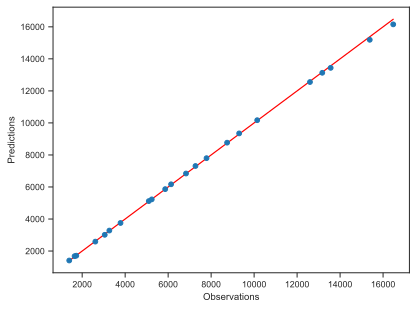

In [38]:
fig, ax = plt.subplots(dpi=100)
yys = np.linspace(y_valid.min(), y_valid.max())
ax.plot(yys, yys, 'r')
ax.plot(y_valid, y_valid_p_mean, 'o')
ax.set_xlabel('Observations')
ax.set_ylabel('Predictions')

Text(0, 0.5, 'Standarized error')

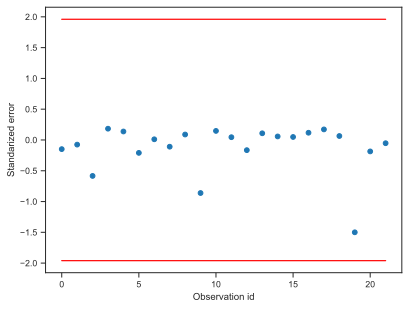

In [39]:
std_errs = (y_valid_p_mean - y_valid) / y_valid_p_std
fig, ax = plt.subplots(dpi=100)
ax.plot(std_errs, 'o')
obs_ids = np.arange(std_errs.shape[0])
ax.plot(obs_ids, 1.96 * np.ones(obs_ids.shape[0]), 'r')
ax.plot(obs_ids, -1.96 * np.ones(obs_ids.shape[0]), 'r')
ax.set_xlabel('Observation id')
ax.set_ylabel('Standarized error')

((array([-1.86607372, -1.43791453, -1.17527742, -0.97550628, -0.80861848,
         -0.66170536, -0.52787584, -0.40291473, -0.28396605, -0.16891711,
         -0.05606845,  0.05606845,  0.16891711,  0.28396605,  0.40291473,
          0.52787584,  0.66170536,  0.80861848,  0.97550628,  1.17527742,
          1.43791453,  1.86607372]),
  array([-1.49961016, -0.86163456, -0.58393895, -0.20959538, -0.18585819,
         -0.16542676, -0.14872212, -0.10918854, -0.07548153, -0.05272707,
          0.0110526 ,  0.0449899 ,  0.04870793,  0.05728456,  0.0643328 ,
          0.08875529,  0.10853073,  0.11750681,  0.1377611 ,  0.14713708,
          0.1716598 ,  0.18319309])),
 (0.34125006747738545, -0.12323961687914657, 0.8205811903810768))

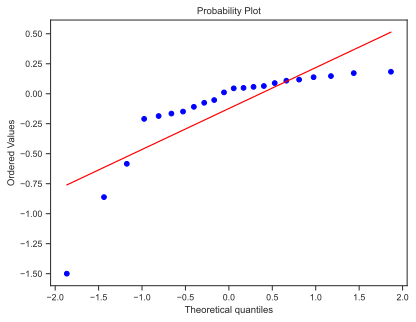

In [40]:
fig, ax = plt.subplots(dpi=100)
st.probplot(std_errs, dist=st.norm, plot=ax)

### Subpart A.II

What is the noise variance you estimated for the Capacity?

In [41]:
sigma = np.sqrt(1.0 / model.alpha_)
print('sigma2 = {0:1.2f}'.format(sigma ** 2))

sigma2 = 958.35


### Subpart A.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Capacity?

[1.00000000e+00 3.96187266e-06 7.66461084e-05 3.87064870e-02
 1.27646500e+03 5.33659689e-01 1.10948699e+05 1.79576871e+04
 3.06442163e+02 8.19158118e+03]


Text(0, 0.5, '$\\alpha_j$')

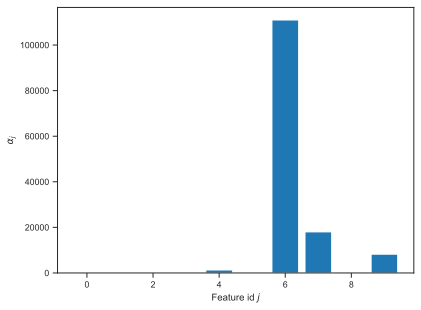

In [42]:
alpha = model.lambda_
print(alpha)
fig, ax = plt.subplots(dpi=100)
ax.bar(np.arange(Phi_train.shape[1]), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')

### Subpart B.I - Fit the Power

Please don't just fit. Split in training and test and use all the usual diagnostics.

In [43]:
y = data['Power'].values
y

array([ 901,  881,  858, 1125, 1122, 1114, 1099, 1075, 1323, 1343, 1356,
       1361, 1354, 1335, 1484, 1534, 1576, 1606, 1624, 1628, 1615, 1600,
       1687, 1764, 1827, 1876, 1909, 1923, 1917, 1663, 1794, 1911, 2014,
       2101, 2169, 2217, 2243, 2246, 1663, 1844, 2010, 2159, 2290, 2400,
       2489, 2554, 2593, 1593, 1830, 2051, 2252, 2434, 2594, 2729, 2839,
       2922, 1442, 1743, 2025, 2286, 2525, 2740, 2929, 3091, 3223])

In [44]:
from sklearn.preprocessing import PolynomialFeatures # For splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.33, random_state=43) # Polynomials features
poly = PolynomialFeatures(degree=3)
# Design matrix for train data
Phi_train = poly.fit_transform(X_train)
# Fit with ARD
model = ARDRegression().fit(Phi_train, y_train)

In [45]:
Phi_valid = poly.fit_transform(X_valid)
y_valid_p_mean, y_valid_p_std = model.predict(Phi_valid, return_std=True)
MSE = np.mean((y_valid_p_mean - y_valid) ** 2)
print('MSE = {0:1.2f}'.format(MSE))

MSE = 4850.18


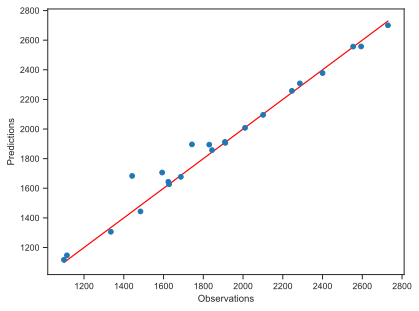

In [46]:
fig, ax = plt.subplots(dpi=100)
yys = np.linspace(y_valid.min(), y_valid.max())
ax.plot(yys, yys, 'r')
ax.plot(y_valid, y_valid_p_mean, 'o')
ax.set_xlabel('Observations')
ax.set_ylabel('Predictions');

Text(0, 0.5, 'Standarized error')

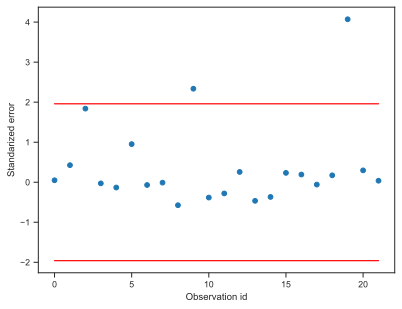

In [47]:
std_errs = (y_valid_p_mean - y_valid) / y_valid_p_std
fig, ax = plt.subplots(dpi=100)
ax.plot(std_errs, 'o')
obs_ids = np.arange(std_errs.shape[0])
ax.plot(obs_ids, 1.96 * np.ones(obs_ids.shape[0]), 'r')
ax.plot(obs_ids, -1.96 * np.ones(obs_ids.shape[0]), 'r')
ax.set_xlabel('Observation id')
ax.set_ylabel('Standarized error')

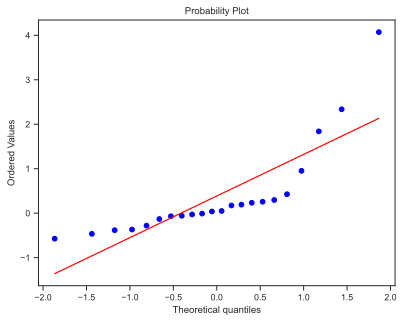

In [48]:
fig, ax = plt.subplots(dpi=100)
st.probplot(std_errs, dist=st.norm, plot=ax);

### Subpart B.II

What is the noise variance you estimated for the Power?

In [49]:
sigma = np.sqrt(1.0 / model.alpha_)
print('sigma2 = {0:1.2f}'.format(sigma ** 2))

sigma2 = 728.48


### Subpart B.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Power?

[1.00000000e+00 3.58660328e-02 4.37875488e-04 1.99197306e+00
 1.37806978e+04 1.34161600e+01 1.97072781e+04 5.06495498e+04
 3.13463392e+03 7.47428954e+04]


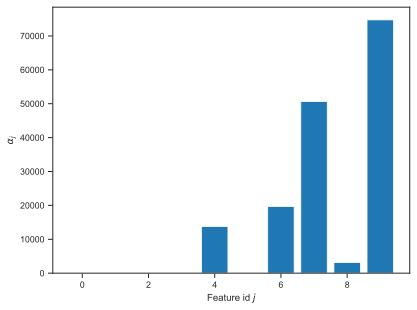

In [50]:
alpha = model.lambda_
print(alpha)
fig, ax = plt.subplots(dpi=100)
ax.bar(np.arange(Phi_train.shape[1]), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
plt.show()

# Problem 3 - Explaining the Challenger disaster
On January 28, 1986, the [Space Shuttle Challenger](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) disintegrated after 73 seconds from launch.
The failure can be traced to the rubber O-rings, which were used to seal the joints of the solid rocket boosters (required to force the hot, high-pressure gases generated by the burning solid propellant through the nozzles, thus producing thrust).

The performance of the O-ring material was sensitive to the external temperature during launch.
This [dataset](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/challenger_data.csv) contains records of different experiments with O-rings recorded at various times between 1981 and 1986.
Download the data the usual way (either put them on Google Drive or run the code cell below).

In [51]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/challenger_data.csv"
download(url)

Even though this is a CSV file, you should load it with pandas because it contains some special characters.

In [52]:
raw_data = pd.read_csv('challenger_data.csv')
raw_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


The first column is the date of the record. The second column is the external temperature of that day in degrees F.
The third column labeled ``Damage Incident`` has a binary coding (0=no damage, 1=damage).
The very last row is the day of the Challenger accident.

We will use the first 23 rows to solve a binary classification problem that will give us the probability of an accident conditioned on the observed external temperature in degrees F. Before proceeding to the data analysis, let's clean the data up.

First, we drop all the bad records:

In [53]:
clean_data_0 = raw_data.dropna()
clean_data_0

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


We also don't need the last record. Remember that the temperature on the day of the Challenger accident was 31 degrees F.

In [54]:
clean_data = clean_data_0[:-1]
clean_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


Let's extract the features and the labels:

In [55]:
x = clean_data['Temperature'].values
x

array([66, 70, 69, 68, 67, 72, 73, 70, 57, 63, 70, 78, 67, 53, 67, 75, 70,
       81, 76, 79, 75, 76, 58])

In [56]:
y = clean_data['Damage Incident'].values.astype(np.float16)
y

array([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1.], dtype=float16)

## Part A - Perform logistic regression

Perform logistic regression between the temperature ($x$) and the damage label ($y$).
Refrain from validating because there is little data.
Just use a simple model so that you don't overfit.

In [57]:
from sklearn.linear_model import LogisticRegression # A constant feature and the observed variable
X = np.hstack([np.ones((x.shape[0], 1)), x[:, None]]) # Fit the model
model = LogisticRegression(penalty='none', fit_intercept=False).fit(X, y)

/Users/krishnan/.venv/me539/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


## Part B - Plot the probability of damage as a function of temperature
Plot the probability of damage as a function of temperature.

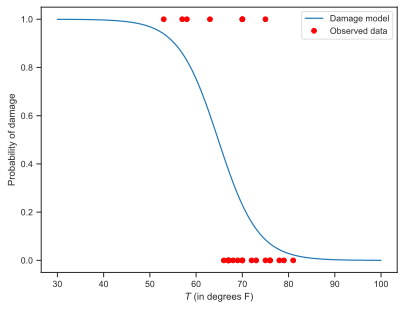

In [59]:
fig, ax = plt.subplots(dpi=100)
# Some temperatures
xx = np.linspace(30, 100, 100)
# We need 2D arrays with the first column being one
XX = np.hstack([np.ones((xx.shape[0], 1)), xx[:, None]]) # Evaluate the probability of damage on the temperatures
yy = model.predict_proba(XX)[:, 1]
# Plot the probability of damage
ax.plot(xx, yy, label='Damage model')
ax.plot(x, y, 'ro', label='Observed data')
ax.set_xlabel('$T$ (in degrees F)')
ax.set_ylabel('Probability of damage')
plt.legend(loc='best')

## Part C - Decide whether or not to launch

The temperature on the day of the Challenger accident was 31 degrees F.
Start by calculating the probability of damage at 31 degrees F.
Then, use formal decision-making (i.e., define a cost matrix and make decisions by minimizing the expected loss) to decide whether or not to launch on that day.
Also, plot your optimal decision as a function of the external temperature.

In [60]:
pdam = model.predict_proba([[1, 31]])[0, 1]
print('Prob of damage at 31 degrees F: {0:1.2f}%'.format(pdam * 100))

Prob of damage at 31 degrees F: 99.96%


Let us consider the following costs.

- Cost of Human Life
- Cost of mission: 
- Cost of destroying shuttle
- Political cost in not launching

According to Wikipedia [(link)](https://en.wikipedia.org/wiki/Value_of_life), the value of a human life is between USD 1 - 10 million. Lets assume $ 7 million for the cost of a human life. With a mission sized for 7 crew members.
<br>
Modern missions are cost-capped at ~$450 million USD [(link)](https://lasp.colorado.edu/mop/files/2019/11/Mission-costs.pdf), Lets use that for the cost of the mission.

I couldn't find any definitive references to the cost of destroying a shuttle, and the political cost, so we will try to propagate uncertainty through these figures.

I am going to assume the cost of destroying the shuttle can be a random value from $25 to 50 billion, and political cost to be $10 - $20 billion. (I am choosing this numbers arbitrarily, if that wasn't already evident)/



Text(0.5, 0, '$T$ (in degrees F)')

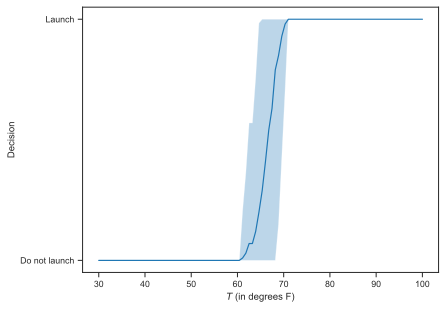

In [74]:
cost_of_human_life = 7 * 1e6
number_of_crew_members = 7
cost_of_mission = 450 * 1e6
# These are subjective numbers (totally unlike the number above)
# However, seriously, lets try to see how the decision boundary
# Varies with respect to this..
nsamples = 100
fig, ax = plt.subplots(dpi=100)
decisions = np.empty((XX.shape[0], nsamples))
for i in range(nsamples):
      cost_of_destroying_shuttle = 25 * 1e9 + 25 * 1e9 * np.random.rand()
      political_cost = 10 * 1e9 + 10 * 1e9 * np.random.rand()
      # Let's use them to put together our cost matrix
      # Cost of not launching when there is no damage
      c00 = political_cost
      # Cost of not launching when there is damage
      c01 = political_cost
      # Cost of launching when there is no damage
      c10 = cost_of_mission
      # Cost of launching when there is damage
      c11 = cost_of_mission + cost_of_destroying_shuttle\
            + number_of_crew_members * cost_of_human_life 
      # Put his in a matrix
      cost_matrix = np.array([[c00, c01],
                              [c10, c11]])
      # Plot of decision boundary
      probs = model.predict_proba(XX)
      exp_cost = np.einsum('ij,kj->ki', cost_matrix, probs)
      decision_idx = np.argmin(exp_cost, axis=1)
      decisions[:,i] = decision_idx
ax.plot(xx, decisions.mean(axis=1))
du = decisions.mean(axis=1) + 1.96 * decisions.std(axis=1)
du[du > 1.0] = 1.0
dl = decisions.mean(axis=1) - 1.96 * decisions.std(axis=1)
dl[dl < 0.0] = 0.0
ax.fill_between(xx, dl, du, alpha=0.3)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Do not launch', 'Launch'])
ax.set_ylabel('Decision')
ax.set_xlabel('$T$ (in degrees F)')

It seems like according to the data and our cost metrics, the decision would flip between the ranges of 60-70 degF. It compliments the findings from the probability of damage.